## Boltz

This notebook demonstrates how to utilize the boltz library to simulate flow around an airfoil.

In [1]:
# Lets import things to check if everything is installed
import torch
import matplotlib.pyplot as plt

In [2]:
# We will use the GPU if available
device = torch.device(f'cuda:{torch.cuda.current_device()}') if torch.cuda.is_available() else 'cpu'
torch.set_default_device(device)
device

'cpu'

In [3]:
import sys
sys.path.append("../")

In [4]:
from pathlib import Path

In [5]:
# Lets create a folder for the resulting images
path = Path().cwd()/"images/circle_barrier/"
path.mkdir(parents=True, exist_ok=True)

In [6]:
from boltz.fluids import Fluid

The first thing is to define a fluid that we will simulate. To define a fluid in LBM we need two characteristics: The speed of sound and the kinematic viscosity.

In [7]:
air = Fluid(
    sound_speed=340,
    kinematic_viscosity=1.562e-5,
)

The next step is to create the Lattice, a grid that holds the fluid information at each point in space.

In [8]:
from boltz.lbm import Lattice

In [9]:
delta_space = 0.6

shape = (100, 500)

In [10]:
lattice = Lattice(
    fluid=air,
    delta_space=delta_space,
    shape=shape
)

In [11]:
lattice.moments.shape

torch.Size([9, 100, 500])

In [12]:
lattice.delta_time

1.0392304845413265

In [13]:
lattice.fluid.tau

0.5196152424057844

Next we will define masks: regions where we apply conditions to the fluid flow. Behind the scenes a mask is a grid of True and False values, where the condition is applied where True and ignored where False.

We can combine different conditions to different masks and place them in diffent places at the lattice. 

One special type of mask implemented is the airfoil wing mask. We will use this mask with a bounce-back condition, that means fluid will colide and bounce-back when they try to enter this region.

In [14]:
from boltz.masks import rectangle, circle

In [15]:
from boltz.utils import bounce_back, accelerate

In [16]:
radius = 10
circle_mask = circle(radius)

/home/wagner/.virtualenvs/torchenv/lib/python3.10/site-packages/torch/functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3609.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


We will also create a rectangle region in space where fluid gains velocity, i.e., its accelerated.

In [17]:
rectangle_mask = rectangle(shape[0], 1)

Finally, we can do the main simulation loop. 

The driving functions to the LBM are the collide and stream functions. Feel free to add callbacks during the event loop to change the simulation. Or at least until it breaks ;)

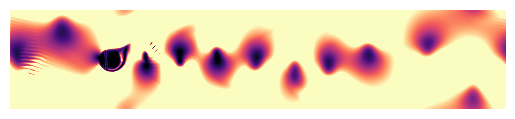

In [18]:
steps = 12000
save_freq = 100
plt.figure(frameon=False);

# main simulation loop
for step in range(steps):
    # A list of callbacks added to the simulation environment
    bounce_back(lattice, circle_mask, anchor=(lattice.shape[0]//2 - radius, 100 - radius))
    accelerate(lattice, rectangle_mask, anchor=(0, 0), force_vector=[0, 0.001])
    accelerate(lattice, rectangle_mask, anchor=(0, lattice.shape[1]), force_vector=[0, -0.001])

    # and the main fluid flow operations
    d, v, eq = lattice.collide()
    lattice.stream()

    if step % save_freq == 0:
        u = v.x ** 2.0 + v.y ** 2.0
        ax = plt.imshow(u.reshape(shape), cmap="magma", vmin=0.0, vmax=0.03);
        plt.axis("off")
        plt.savefig(path/ f"{step}.png", bbox_inches="tight", pad_inches=0)

In [19]:
u.mean()

tensor(0.0356)

At any time we can plot lattice information and check if this are going as expected

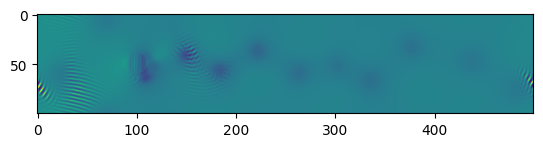

In [20]:
plt.imshow(d.reshape(shape));

In [21]:
velocity = v
U = velocity.x ** 2. + velocity.y ** 2.

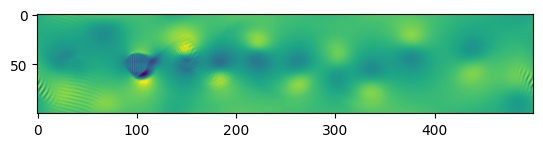

In [22]:
plt.imshow(velocity.y.reshape(shape));

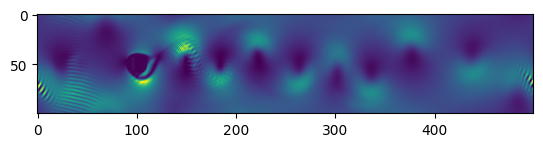

In [23]:
plt.imshow(U.reshape(shape));